In [1]:
import apogee.spec.plot as splot
import apogee.tools.read as apread
import numpy as np
from apogee.modelspec import ferre
from apogee.spec import continuum
import apogee.spec.plot as splot
import matplotlib.pyplot as plt
%matplotlib inline

import BinModelGen as bm
import BinPlot
from BinaryGrid import calcChi2
from GridParam import GridParam
from Timer import Timer

In [2]:
locationID = 4586
apogeeID = '2M03441568+3231282'
restLamda = splot.restLambda = splot.apStarWavegrid()
visit = 1

badheader, header = apread.apStar(locationID, apogeeID, ext=0, header=True)

gridParam = GridParam(locationID, apogeeID)
gridParam.constructParams()

# Stage 1 - Aquiring The Visit Spectrum
Get the visit spectrum. Since the first two are combined spectra we skip them.

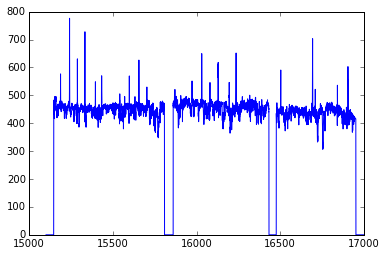

In [3]:
spec = apread.apStar(locationID, apogeeID, ext=1, header=False)[1 + visit]
specerr = apread.apStar(locationID, apogeeID, ext=2, header=False)[1 + visit]
plt.plot(restLamda, spec)

# Stage 2 - Continuum-Normalization and Shifting
Continuum-normalize the visit spectrum and its error.

After this is done, the spectrum is shifted by its heliocentric velocity correction in order to bring it back into the stars frame.

/Users/harleyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()

/Users/harleyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()

/Users/harleyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide



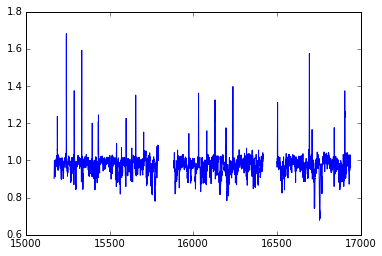

In [4]:
aspec= np.reshape(spec,(1, len(spec)))
aspecerr= np.reshape(specerr,(1, len(specerr)))
cont= spec / continuum.fit(aspec, aspecerr, type='aspcap')[0]
conterr = specerr / continuum.fit(aspec, aspecerr, type='aspcap')[0]
shiftedSpec = bm.shiftFlux(cont, header['VHELIO' + str(visit)])
conterr = bm.shiftFlux(cont, header['VHELIO' + str(visit)])
plt.plot(restLamda, cont)

# Stage 3 - Model Generation
Next comes generating both of the components of the binary.

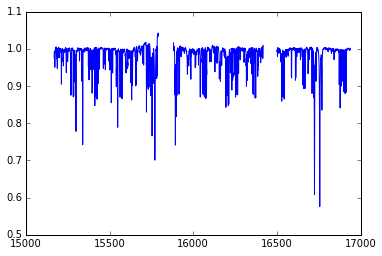

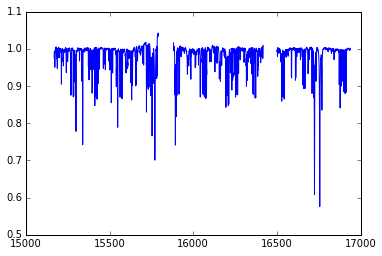

In [5]:
ipg = ferre.Interpolator(lib='GK')
ipf = ferre.Interpolator(lib='F')

componentA = bm.genComponent(gridParam.modelParamA, ipf, ipg)
plt.plot(restLamda, componentA)
plt.show()
componentB = bm.genComponent(gridParam.modelParamB, ipf, ipg)
plt.plot(restLamda, componentB)
plt.show()

ipg.close()
ipf.close()

# Stage 4 - Applying The Flux Ratio
The flux ratio is then applied to the the secondary component of the binary (component B)

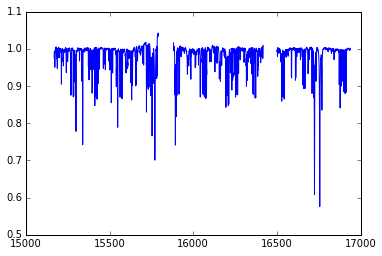

In [6]:
componentBR = componentB * gridParam.modelParamB.fluxRatio
plt.plot(restLamda, componentBR)

# Stage 5 - Model Shift
This stage shifts both of the model components by their approximated heliocentric velocities to get the model in the stars frame.

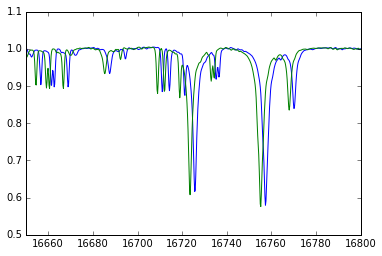

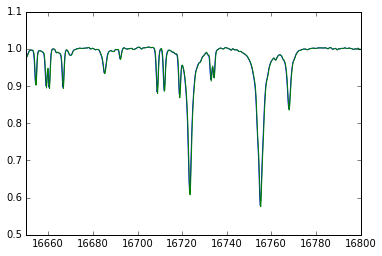

In [7]:
gridParam.getRVs(visit)
componentAS = bm.shiftFlux(componentA, gridParam.modelParamA.rv)
plt.plot(restLamda, componentAS, color='blue')
plt.plot(restLamda, componentA, color='green')
plt.xlim(16650, 16800)
plt.show()
componentBS = bm.shiftFlux(componentBR, gridParam.modelParamB.rv)
plt.plot(restLamda, componentBS, color='blue')
plt.plot(restLamda, componentBR, color='green')
plt.xlim(16650, 16800)
plt.show()

# Stage 6 - Binary Model and Chi2 Calculation
This is the final stage of the grid where the flux from both components are combined and a chi2 value comparing the binary model against the visit spectrum.

0.00125192486396


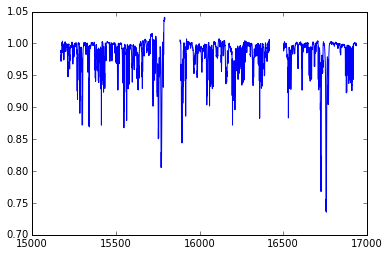

In [8]:
binaryFlux = bm.combineFlux(componentAS, componentBS)
chi2 = calcChi2(binaryFlux, shiftedSpec, conterr) / (len(binaryFlux) - 5)
print(chi2)
plt.plot(restLamda, binaryFlux)